In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
import onnxruntime as rt
from sklearn.metrics import accuracy_score


=== BAD MODEL PERFORMANCE ===
Accuracy: 0.9430740037950665

=== GOOD MODEL PERFORMANCE ===
Accuracy: 0.9433902593295382

=== VALIDATING ONNX MODELS ===
model_1.onnx accuracy: 0.9430740037950665
model_2.onnx accuracy: 0.9433902593295382

FEATURE IMPORTANCE ANALYSIS: REVEALING INTENTIONAL BIAS IN MODEL 1

--- MODEL 1 (BAD - BIASED) TOP 25 MOST IMPORTANT FEATURES ---
Rank   Feature Name                                       Importance  
--------------------------------------------------------------------
1      persoon_leeftijd_bij_onderzoek                     0.226428    
2      pla_historie_ontwikkeling                          0.121892    
3      ontheffing_dagen_hist_vanwege_uw_medische_omstandigheden 0.072993    
4      contacten_onderwerp_no_show                        0.067570    
5      relatie_overig_kostendeler                         0.043555    
6      relatie_overig_actueel_vorm__kostendeler           0.043199    
7      contacten_soort_afgelopenjaar_document__uitgaand_  0.

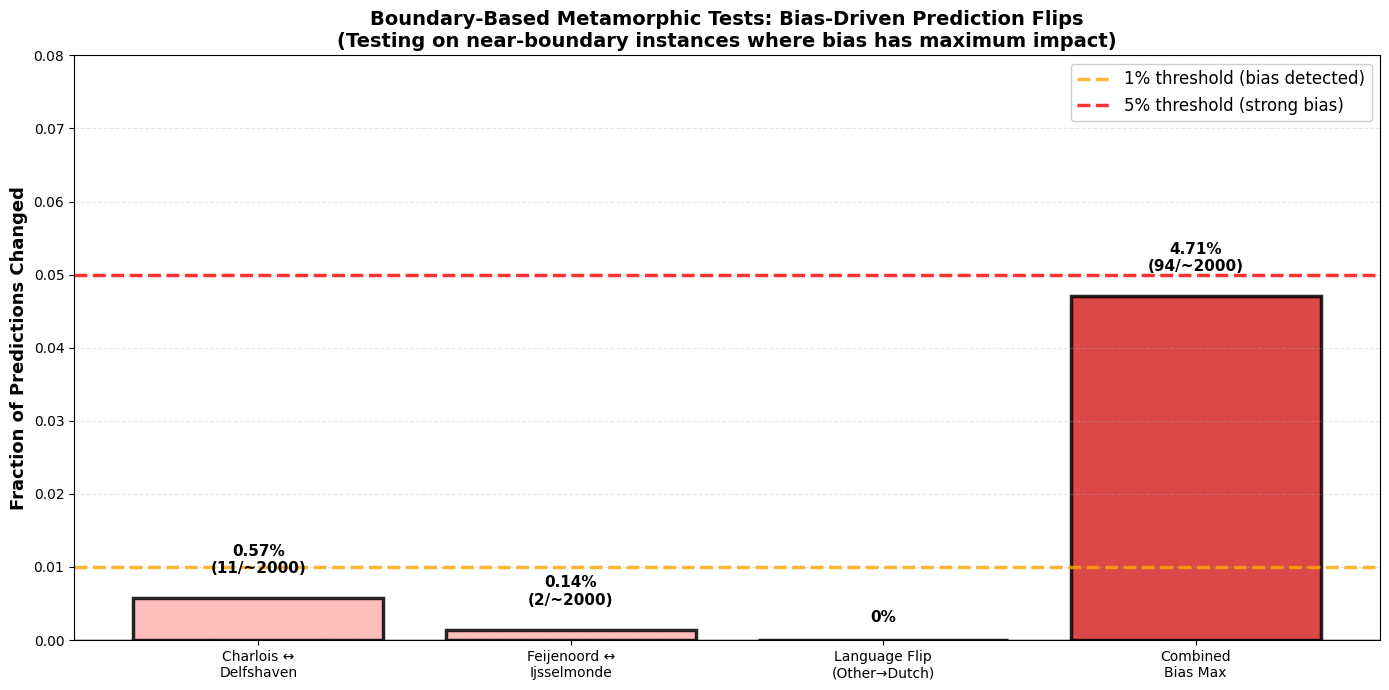


📊 Numerical Summary:
   Average prediction change rate: 1.36%
   Maximum prediction change rate: 4.71%

 MODERATE BIAS: Some boundary predictions are affected by bias features.

GENERATING BIAS VISUALIZATION
Visualization saved as 'bias_comparison_visualization.png'


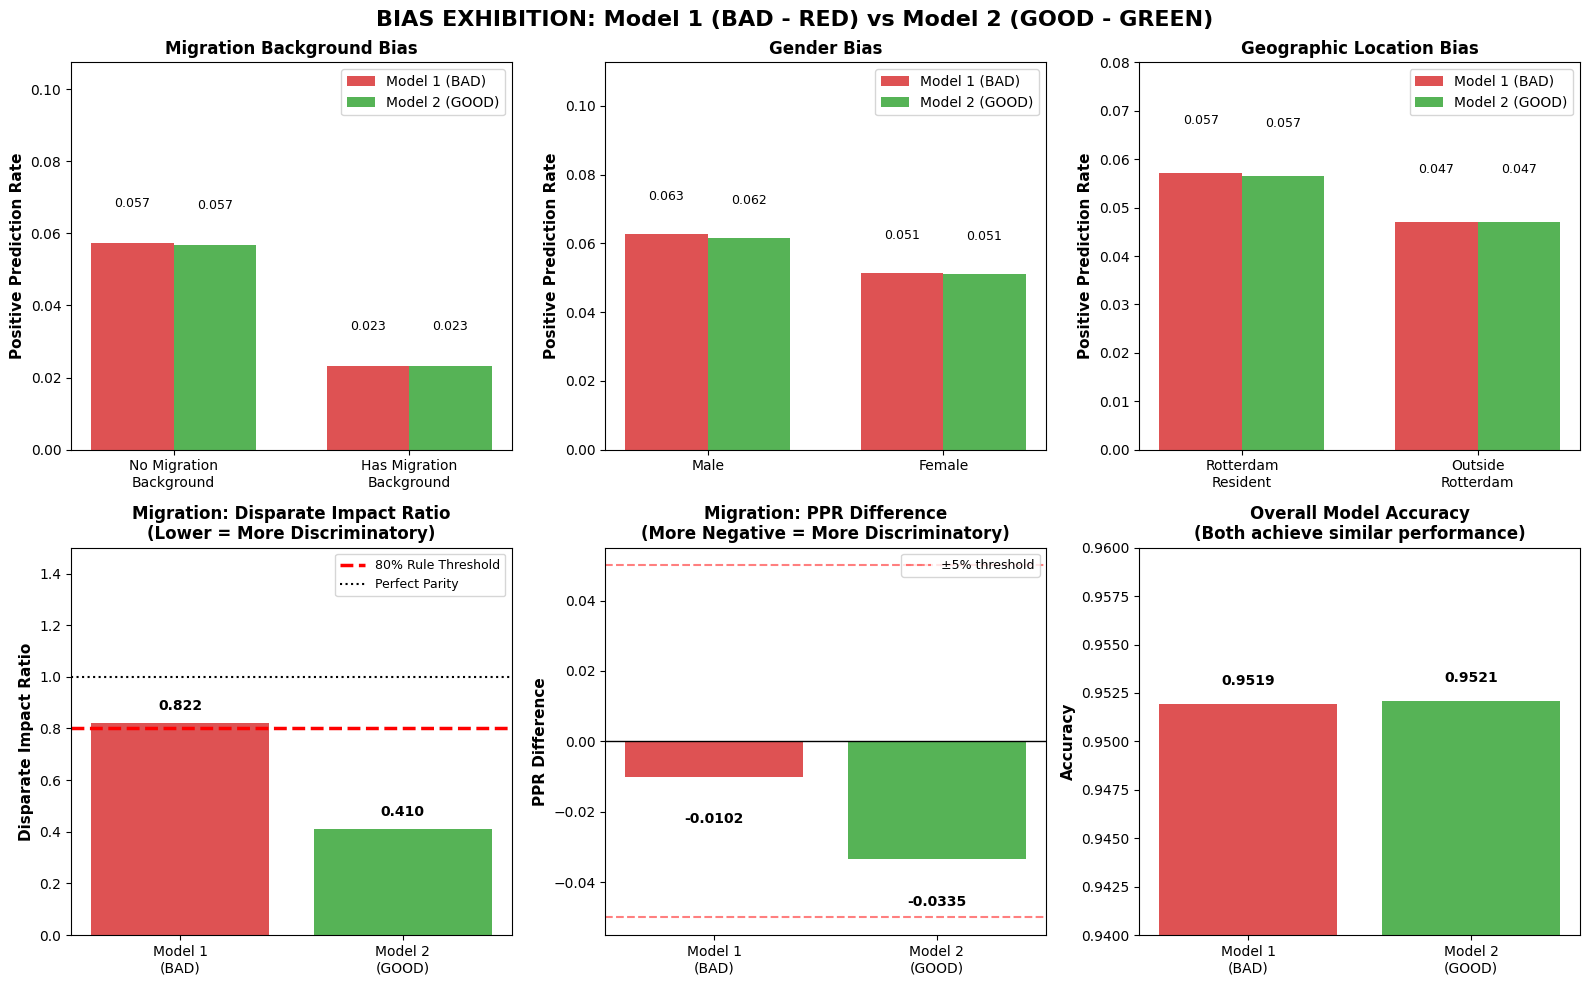

In [2]:
%run pipeline_models_group1.ipynb

[Subgroup B] BAD model accuracy: 0.9440227703984819
[Subgroup B] GOOD model accuracy: 0.9275774826059456

[Subgroup B] Saved:
  BAD  -> group2/model_1.onnx
  GOOD -> group2/model_2.onnx
[Subgroup B] Loaded data: 12645 rows, 315 features.

[Subgroup B] Loading ONNX models...
Model B1 (BAD) expects 318 features.
We provide 318 features.
Model B2 (GOOD) expects 310 features.
We provide 310 features.

=== SUBGROUP B: BASE ACCURACY CHECK (correct feature views) ===
model_B1 (BAD)  accuracy=0.9522, pos_rate=0.058
model_B2 (GOOD) accuracy=0.9378, pos_rate=0.043

=== PARTITION TESTS for model_B1 (BAD) ===
Global accuracy: 0.952, positive rate: 0.058

Partition on age buckets (persoon_leeftijd_bij_onderzoek)
  age_group= <=30: n= 566, acc=0.935, pos_rate=0.254
  age_group=31-45: n=3723, acc=0.934, pos_rate=0.113
  age_group=46-60: n=6542, acc=0.964, pos_rate=0.014
  age_group= >=61: n=1814, acc=0.953, pos_rate=0.042

Partition on column: persoonlijke_eigenschappen_taaleis_voldaan (values: [0. 1

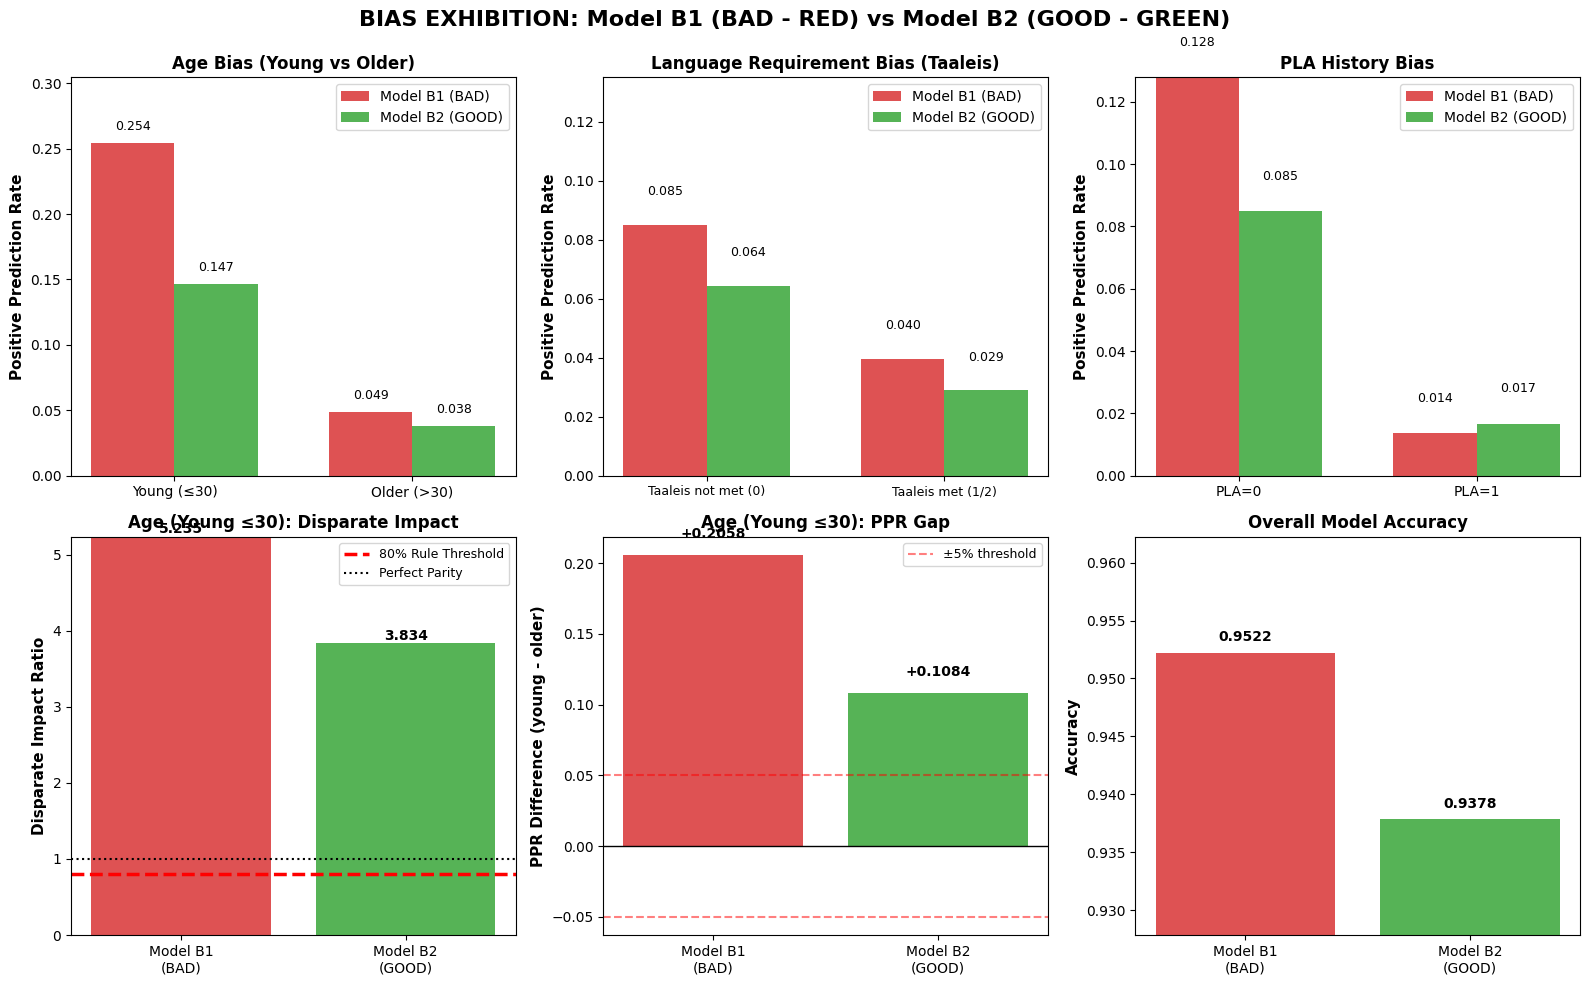

In [3]:
%run pipeline_models_group2.ipynb

In [4]:
# Paths (adjust if needed)
DATA_PATH      = Path("data/synth_data_for_training.csv")
MODEL_G1_BAD   = Path("group1/model_1.onnx")
MODEL_G1_GOOD  = Path("group1/model_2.onnx")
MODEL_G2_BAD   = Path("group2/model_1.onnx")
MODEL_G2_GOOD  = Path("group2/model_2.onnx")

# ---------- load raw data ----------
df_all = pd.read_csv(DATA_PATH)
y_all = df_all["checked"].astype(int)
X_raw_all = df_all.drop(columns=["checked"]).astype(np.float32)

print(f"[CROSS] Loaded data: {X_raw_all.shape[0]} rows, {X_raw_all.shape[1]} features.")

# ---------- build feature views for each model ----------

# Subgroup 1 views
X_G1_BAD_view  = engineer_bias_features(X_raw_all.copy())
feat_G1_BAD    = list(X_G1_BAD_view.columns)

X_G1_GOOD_view = X_raw_all.drop(columns=sensitive_columns)
feat_G1_GOOD   = list(X_G1_GOOD_view.columns)

# Subgroup 2 views
X_G2_BAD_view  = engineer_bias_features_B(X_raw_all.copy())
feat_G2_BAD    = list(X_G2_BAD_view.columns)

X_G2_GOOD_view = X_raw_all.drop(columns=[c for c in sensitive_columns_B if c in X_raw_all.columns])
feat_G2_GOOD   = list(X_G2_GOOD_view.columns)

print(f"[CROSS] G1_BAD view  dim: {X_G1_BAD_view.shape}")
print(f"[CROSS] G1_GOOD view dim: {X_G1_GOOD_view.shape}")
print(f"[CROSS] G2_BAD view  dim: {X_G2_BAD_view.shape}")
print(f"[CROSS] G2_GOOD view dim: {X_G2_GOOD_view.shape}")

# ---------- utility: load ONNX ----------

def load_onnx(path: Path) -> rt.InferenceSession:
    if not path.exists():
        raise FileNotFoundError(path)
    return rt.InferenceSession(path.as_posix(), providers=["CPUExecutionProvider"])

sess_G1_BAD  = load_onnx(MODEL_G1_BAD)
sess_G1_GOOD = load_onnx(MODEL_G1_GOOD)
sess_G2_BAD  = load_onnx(MODEL_G2_BAD)
sess_G2_GOOD = load_onnx(MODEL_G2_GOOD)

print("\n[CROSS] ONNX sessions loaded.")

# ---------- sanity: base accuracy of each model on own view ----------
preds_G1_BAD  = predict_onnx(sess_G1_BAD,  X_G1_BAD_view,  feat_G1_BAD)
preds_G1_GOOD = predict_onnx(sess_G1_GOOD, X_G1_GOOD_view, feat_G1_GOOD)
preds_G2_BAD  = predict_onnx(sess_G2_BAD,  X_G2_BAD_view,  feat_G2_BAD)
preds_G2_GOOD = predict_onnx(sess_G2_GOOD, X_G2_GOOD_view, feat_G2_GOOD)

print("\n=== BASE ACCURACY CHECK (own feature views) ===")
print(f"G1_BAD   acc={accuracy_score(y_all, preds_G1_BAD):.4f},  pos_rate={preds_G1_BAD.mean():.3f}")
print(f"G1_GOOD  acc={accuracy_score(y_all, preds_G1_GOOD):.4f}, pos_rate={preds_G1_GOOD.mean():.3f}")
print(f"G2_BAD   acc={accuracy_score(y_all, preds_G2_BAD):.4f},  pos_rate={preds_G2_BAD.mean():.3f}")
print(f"G2_GOOD  acc={accuracy_score(y_all, preds_G2_GOOD):.4f}, pos_rate={preds_G2_GOOD.mean():.3f}")

[CROSS] Loaded data: 12645 rows, 315 features.
[CROSS] G1_BAD view  dim: (12645, 317)
[CROSS] G1_GOOD view dim: (12645, 307)
[CROSS] G2_BAD view  dim: (12645, 318)
[CROSS] G2_GOOD view dim: (12645, 310)

[CROSS] ONNX sessions loaded.

=== BASE ACCURACY CHECK (own feature views) ===
G1_BAD   acc=0.9519,  pos_rate=0.057
G1_GOOD  acc=0.9521, pos_rate=0.057
G2_BAD   acc=0.9522,  pos_rate=0.058
G2_GOOD  acc=0.9378, pos_rate=0.043


In [5]:
# ============================================================
# SUB-GROUP 1 TEST SUITE ON ANY MODEL
# ============================================================

def run_subgroup1_suite_on_model(X_view: pd.DataFrame,
                                 X_raw: pd.DataFrame,
                                 y: pd.Series,
                                 sess: rt.InferenceSession,
                                 feature_cols,
                                 label: str):
    """
    Apply Sub-group 1's fairness suite (partition, metamorphic, counterfactual, DI)
    to an arbitrary ONNX model.

    X_view:  DataFrame used as input to ONNX (correct feature engineering already applied)
    X_raw:   Raw dataframe (not strictly needed here, but kept for symmetry / extension)
    y:       Ground truth labels
    sess:    ONNX inference session
    feature_cols: column order for ONNX input
    label:   Human-readable model label to print
    """
    print("\n" + "="*90)
    print(f"SUB-GROUP 1 TESTS APPLIED TO: {label}")
    print("="*90)

    # predictions (used in DI report)
    preds = predict_onnx(sess, X_view, feature_cols)
    print(f"[{label}] accuracy={accuracy_score(y, preds):.4f}, pos_rate={preds.mean():.3f}")

    # 1) Partition tests (migration/geography/gender/age)
    run_partition_tests(X_view, y, sess, feature_cols, model_label=label)

    # 2) Metamorphic tests (wijk swaps + language flip)
    run_metamorphic_tests(X_view, sess, feature_cols, model_label=label)

    # 3) Counterfactual tests (gender, inburgering, taaleis)
    run_counterfactual_tests(X_view, sess, feature_cols, model_label=label)

    # 4) Disparate impact report (migration, gender, outside-Rdam)
    print_disparate_impact_report(X_view, y, preds, model_label=label)

In [6]:
# ============================================================
# RUN SUB-GROUP 1 TESTS ON ALL FOUR MODELS
# ============================================================

# On own models (optional, for compact “Section 3” tables)
run_subgroup1_suite_on_model(X_G1_BAD_view,  X_raw_all, y_all, sess_G1_BAD,  feat_G1_BAD,  "G1_BAD (our own bad)")
run_subgroup1_suite_on_model(X_G1_GOOD_view, X_raw_all, y_all, sess_G1_GOOD, feat_G1_GOOD, "G1_GOOD (our own good)")

# On subgroup 2 models – this is what you need for the report
run_subgroup1_suite_on_model(X_G2_BAD_view,  X_raw_all, y_all, sess_G2_BAD,  feat_G2_BAD,  "G2_BAD under G1 tests")
run_subgroup1_suite_on_model(X_G2_GOOD_view, X_raw_all, y_all, sess_G2_GOOD, feat_G2_GOOD, "G2_GOOD under G1 tests")


SUB-GROUP 1 TESTS APPLIED TO: G1_BAD (our own bad)
[G1_BAD (our own bad)] accuracy=0.9519, pos_rate=0.057

=== PARTITION TESTS for G1_BAD (our own bad) ===
Global accuracy: 0.952, positive rate: 0.057

Partition on binary column: persoon_geslacht_vrouw
  value=0: n=6542, acc=0.954, pos_rate=0.063
  value=1: n=6103, acc=0.950, pos_rate=0.051

Partition on binary column: typering_hist_inburgeringsbehoeftig
  value=0: n=12559, acc=0.952, pos_rate=0.057
  value=1: n=  86, acc=0.930, pos_rate=0.023

Partition on binary column: persoonlijke_eigenschappen_taaleis_voldaan
  value=0: n=5043, acc=0.935, pos_rate=0.083
  value=1: n=7011, acc=0.966, pos_rate=0.034

Partition on binary column: adres_recentste_wijk_charlois
  value=0: n=11351, acc=0.951, pos_rate=0.058
  value=1: n=1294, acc=0.962, pos_rate=0.049

Partition on binary column: adres_recentste_wijk_delfshaven
  value=0: n=10955, acc=0.953, pos_rate=0.057
  value=1: n=1690, acc=0.944, pos_rate=0.061

Partition on binary column: adres_r

In [12]:
# ============================================================
# SUB-GROUP 2: DI report for a single model
# ============================================================

def print_di_report_B_single_model(X_raw: pd.DataFrame,
                                   y: pd.Series,
                                   preds: np.ndarray,
                                   label: str):
    """
    Use Sub-group 2's DI machinery (age, taaleis, ambition, children, PLA)
    for a single model.
    """
    print("\n" + "-"*90)
    print(f"SUB-GROUP 2 DI METRICS for {label}")
    print("-"*90)

    X_di = build_di_view_B(X_raw)

    # Same axes as in print_disparate_impact_report_B
    calculate_di_for_binary_attr(X_di, y, preds,
                                 "young_leq_30", "Age: young (≤30)")
    calculate_di_for_binary_attr(X_di, y, preds,
                                 "taaleis_not_met", "Taaleis not met")
    calculate_di_for_binary_attr(X_di, y, preds,
                                 "no_ambition", "No ambition")
    calculate_di_for_binary_attr(X_di, y, preds,
                                 "many_children", "Many children (>2)")
    calculate_di_for_binary_attr(X_di, y, preds,
                                 "pla_ontwikkeling_1", "PLA historie ontwikkeling=1")

In [13]:
def build_view_for_model(label: str, X_raw_slice: pd.DataFrame) -> pd.DataFrame:
    """
    Given a human-readable label ('G1_BAD under G2 tests', 'G2_BAD (own bad)', etc.)
    build the correct feature view that corresponds to the ONNX model.

    Uses the same logic as you used when constructing:
      - X_G1_BAD_view  (engineer_bias_features)
      - X_G1_GOOD_view (drop sensitive_columns)
      - X_G2_BAD_view  (engineer_bias_features_B)
      - X_G2_GOOD_view (drop sensitive_columns_B)
    """
    # Make a copy to be safe
    X = X_raw_slice.copy()

    # GROUP 1 MODELS
    if "G1_BAD" in label:
        # needs geo_bias_feature + mig_bias_feature
        X = engineer_bias_features(X)
    elif "G1_GOOD" in label:
        # needs sensitive columns of group 1 removed
        X = X.drop(columns=[c for c in sensitive_columns if c in X.columns])

    # GROUP 2 MODELS
    elif "G2_BAD" in label:
        # needs Subgroup 2 bias features (age/taaleis/behaviour)
        X = engineer_bias_features_B(X)
    elif "G2_GOOD" in label:
        # needs Subgroup 2 sensitive/proxy columns removed
        X = X.drop(columns=[c for c in sensitive_columns_B if c in X.columns])

    # Fallback: identity (if you ever add extra models)
    return X

In [14]:
def metamorphic_flip_numeric(
    X_raw,
    sess,
    feature_cols,
    col,
    from_cond,
    to_value,
    sample_size=1500,
    label=""
):
    """
    Generic numeric metamorphic flip:
      - filter rows where `from_cond` holds on column `col`
      - change column to `to_value`
      - rebuild *the correct feature view for this model*
      - compare predictions before/after

    Uses `build_view_for_model(label, X_sub)` so that engineered features
    (geo_bias_feature, mig_bias_feature, etc.) are recomputed if needed.
    """
    if col not in X_raw.columns:
        print(f"\n[{label}] Metamorphic: column '{col}' missing – skipped.")
        return None

    print(f"\n[{label}] Metamorphic flip on '{col}': from condition -> {to_value}")

    series = X_raw[col]
    mask = from_cond(series)

    idx_candidates = X_raw[mask].index
    if len(idx_candidates) == 0:
        print(f"  No rows satisfy from_cond for column '{col}' – skipped.")
        return None

    if len(idx_candidates) > sample_size:
        idx = np.random.choice(idx_candidates, size=sample_size, replace=False)
    else:
        idx = idx_candidates

    # 1) Original slice in RAW space
    X_sub_raw = X_raw.loc[idx].copy()

    # 2) Build the model-specific view for original
    X_view_orig = build_view_for_model(label, X_sub_raw)
    preds_orig = predict_onnx(sess, X_view_orig, feature_cols)

    # 3) Counterfactual: modify the raw column, then rebuild the view
    X_cf_raw = X_sub_raw.copy()
    X_cf_raw[col] = to_value

    X_view_cf = build_view_for_model(label, X_cf_raw)
    preds_cf = predict_onnx(sess, X_view_cf, feature_cols)

    changed = (preds_orig != preds_cf).mean()
    print(f"  Tested on {len(idx)} examples.")
    print(f"  Prediction flips after change: {changed * 100:.2f}%")

    return changed


def run_subgroup2_metamorphic_on_model(X_raw, sess, feature_cols, label=""):
    print("\n" + "-"*90)
    print(f"SUB-GROUP 2 METAMORPHIC TESTS on {label}")
    print("-"*90)

    # Age: young (≤30) -> 40
    metamorphic_flip_numeric(
        X_raw, sess, feature_cols,
        col="persoon_leeftijd_bij_onderzoek",
        from_cond=lambda s: s <= 30,
        to_value=40.0,
        label=label + " [age ≤30 → 40]"
    )

    # Taaleis: 0 -> 1
    metamorphic_flip_numeric(
        X_raw, sess, feature_cols,
        col="persoonlijke_eigenschappen_taaleis_voldaan",
        from_cond=lambda s: s == 0,
        to_value=1.0,
        label=label + " [taaleis 0→1]"
    )

    # Ambition: 0 -> 1
    metamorphic_flip_numeric(
        X_raw, sess, feature_cols,
        col="competentie_gedrevenheid_en_ambitie_tonen",
        from_cond=lambda s: s == 0,
        to_value=1.0,
        label=label + " [ambitie 0→1]"
    )

In [15]:
# ============================================================
# SUB-GROUP 2 TEST SUITE ON ANY MODEL
# ============================================================

def run_subgroup2_suite_on_model(X_view: pd.DataFrame,
                                 X_raw: pd.DataFrame,
                                 y: pd.Series,
                                 sess: rt.InferenceSession,
                                 feature_cols,
                                 label: str):
    """
    Apply Sub-group 2's fairness suite (partition tests, DI metrics,
    and age/taaleis/ambition metamorphic flips) to any ONNX model.
    """
    print("\n" + "="*90)
    print(f"SUB-GROUP 2 TESTS APPLIED TO: {label}")
    print("="*90)

    preds = predict_onnx(sess, X_view, feature_cols)
    print(f"[{label}] accuracy={accuracy_score(y, preds):.4f}, pos_rate={preds.mean():.3f}")

    # 1) Partition tests on subgroup-2 axes (age, taaleis, ambition, kids, PLA)
    run_partition_tests_B(X_view, y, preds, model_label=label)

    # 2) DI metrics
    print_di_report_B_single_model(X_raw, y, preds, label=label)

    # 3) Metamorphic flips for age, taaleis, ambition
    run_subgroup2_metamorphic_on_model(X_raw, sess, feature_cols, label=label)

In [16]:
run_subgroup2_suite_on_model(X_G1_BAD_view,  X_raw_all, y_all, sess_G1_BAD,  feat_G1_BAD,  "G1_BAD under G2 tests")
run_subgroup2_suite_on_model(X_G1_GOOD_view, X_raw_all, y_all, sess_G1_GOOD, feat_G1_GOOD, "G1_GOOD under G2 tests")
run_subgroup2_suite_on_model(X_G2_BAD_view,  X_raw_all, y_all, sess_G2_BAD,  feat_G2_BAD,  "G2_BAD (own bad)")
run_subgroup2_suite_on_model(X_G2_GOOD_view, X_raw_all, y_all, sess_G2_GOOD, feat_G2_GOOD, "G2_GOOD (own good)")


SUB-GROUP 2 TESTS APPLIED TO: G1_BAD under G2 tests
[G1_BAD under G2 tests] accuracy=0.9519, pos_rate=0.057

=== PARTITION TESTS for G1_BAD under G2 tests ===
Global accuracy: 0.952, positive rate: 0.057

Partition on age buckets (persoon_leeftijd_bij_onderzoek)
  age_group= <=30: n= 566, acc=0.929, pos_rate=0.253
  age_group=31-45: n=3723, acc=0.934, pos_rate=0.111
  age_group=46-60: n=6542, acc=0.964, pos_rate=0.014
  age_group= >=61: n=1814, acc=0.952, pos_rate=0.041

Partition on column: persoonlijke_eigenschappen_taaleis_voldaan (values: [0. 1. 2.])
  v=0.0: n=5043, acc=0.935, pos_rate=0.083
  v=1.0: n=7011, acc=0.966, pos_rate=0.034
  v=2.0: n= 591, acc=0.936, pos_rate=0.115

Partition on column: competentie_gedrevenheid_en_ambitie_tonen (values: [0. 1. 2.])
  v=0.0: n=10516, acc=0.955, pos_rate=0.054
  v=1.0: n=2128, acc=0.935, pos_rate=0.075
  v=2.0: group too small (n=1) – skipped.

Partition on column: relatie_kind_huidige_aantal (values: [0. 1. 2. 3. 4.])
  v=0.0: n=4443, a